# Chapter 18: Doing reproducible research

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile, pearsonr
from scipy.spatial.distance import cdist
import pingouin as pg
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
%load_ext rpy2.ipython

%matplotlib inline 
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter

rng = np.random.default_rng(1234567)

### Figure 18.1

Posterior predictive value and statistical significance


<Axes: xlabel='power', ylabel='PPV'>

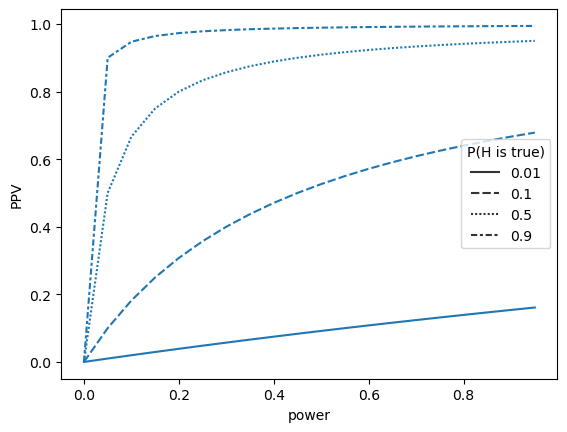

In [2]:
alpha = 0.05  # false positive rate
beta = np.arange(1.,0.00,-0.05)  # false negative rate
powerVals = list(1 - beta)
priorVals = [.01,0.1,0.5,0.9]
nstudies = 100

df = pd.DataFrame({'power': powerVals * len(priorVals), 'alpha': alpha})
df['P(H is true)'] = np.kron(priorVals, np.ones(len(powerVals)))

def PPV(df):
  ppv = (df.power * df['P(H is true)']) / (df.power * df['P(H is true)']  +  df.alpha * (1-df['P(H is true)']))
  return(ppv)

df['PPV'] = PPV(df)

sns.lineplot(data=df, x='power', y='PPV', style='P(H is true)')

### Figure 18.2

The winner's curse


In [3]:
trueEffectSize=0.2
dfCurse = pd.DataFrame({'sampSize': np.arange(20, 301, 20), 
        'effectSize': trueEffectSize, 'alpha': .05, 
                        'power': np.nan, 'effectSizeEstimate': np.nan})


def sim_curse (sampSize, effectSize, alpha=.05, nruns=1000):
    sigResults = 0
    sigEffects = []
    allEffects = []
    isSignificant = []
    for i in range(nruns):
        tmpData = rng.normal(size=sampSize, loc=effectSize, scale = 1)
        tt = pg.ttest(x=tmpData, y=0)
        allEffects.append(tt['cohen-d'][0])
        isSignificant.append(tt['p-val'][0] < alpha)
        if (tt['p-val'][0] < alpha):
          sigResults += 1
          sigEffects.append(tt['cohen-d'][0])
    return(sigResults/nruns, np.mean(sigEffects), allEffects, isSignificant)


for i in dfCurse.index:
    dfCurse.loc[i, 'power'], dfCurse.loc[i, 'effectSizeEstimate'], _, _ = sim_curse(dfCurse.loc[i, 'sampSize'], dfCurse.loc[i, 'effectSize'])

In [4]:

sampSize=60
effectSize=0.2

_, _, allEffects, isSignificant = sim_curse(sampSize, effectSize)
esDf = pd.DataFrame({'effectSizeEstimate': allEffects, 'isSignificant': isSignificant})

<Axes: xlabel='effectSizeEstimate', ylabel='Count'>

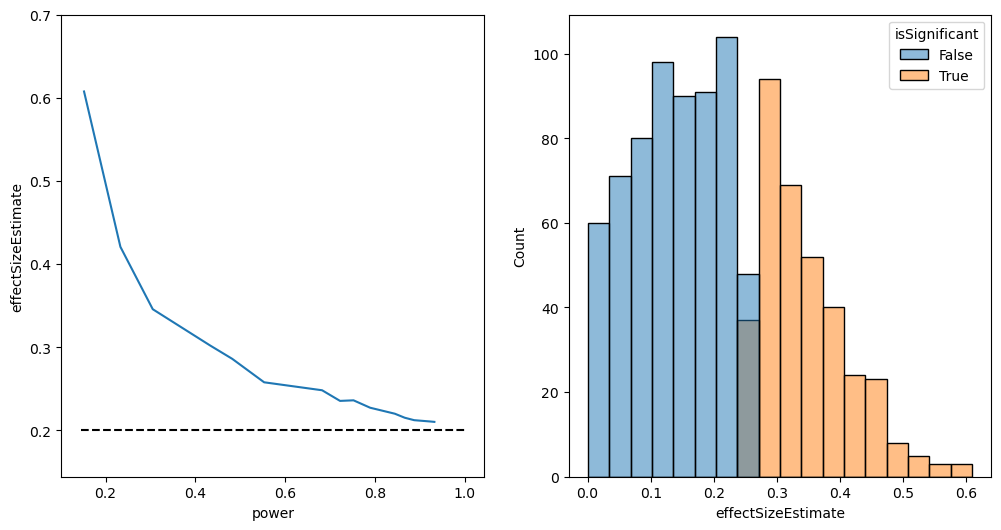

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.lineplot(data=dfCurse, x='power', y='effectSizeEstimate', ax=ax[0])
xmin = dfCurse.power.min()*.95
ax[0].set_ylim((xmin, 0.7))
ax[0].plot([xmin, 1], [trueEffectSize, trueEffectSize], 'k--')

sns.histplot(data=esDf, x='effectSizeEstimate', hue='isSignificant', ax=ax[1])